In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tokenize import PunktSentenceTokenizer 
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
from sklearn.ensemble import RandomForestRegressor
from transformers import RobertaTokenizer
from sklearn.linear_model import ElasticNet

In [2]:
df_train = pd.read_csv('train.csv')
df_train = df_train.drop(['url_legal','standard_error','license'], axis = 1)
df_train['batch']='train'

df_test = pd.read_csv('test.csv')
df_test = df_test.drop(['url_legal','license'], axis = 1)
df_test['target'] = 0
df_test['batch']='test'

df = pd.concat([df_train,df_test], ignore_index = True)
df = df.rename(columns={'id':'identifiant_'})

In [3]:
df3 = df.copy()

def nb_world(text):
    word_liste = text.split()
    n = len(word_liste)
    return n

df3['nb_w']= df3.excerpt.apply(lambda x : nb_world(x))
df3['nb_car']=df3.excerpt.apply(lambda x : len(x))
df3['car_w']=df3.nb_car/df3.nb_w

In [4]:
# Comptage des lettres

# Création  de la liste des lettres de l'alphabet
alpha_liste = list(string.ascii_lowercase)
occur_letter =[]
l_array = np.zeros((len(df3),26))

col = -1
for l in alpha_liste:
    col +=1
    ligne = -1
    count = 0
    for t in df3.excerpt:
        ligne += 1
        for i in t:
            if i.lower()==l:
                count+=1
        l_array[ligne,col]=count
        
# liste double lettre
double_lettre = []
for l1 in alpha_liste:
    for l2 in alpha_liste:
        l = l1+l2
        double_lettre.append(l)
        
double_array = np.zeros((len(df3),26*26))

col = -1
for l in double_lettre:
    col +=1
    ligne = -1
    for t in df3.excerpt:
        ligne += 1
        d = re.findall(l,t)
        double_array[ligne,col]=len(d)
        
# liste tripple lettre
triple_lettre = []
for l1 in alpha_liste:
    for l2 in alpha_liste:
        for l3 in alpha_liste:
            l = l1+l2+l3
            triple_lettre.append(l)
        
triple_array = np.zeros((len(df3),26*26*26))

col = -1
for l in triple_lettre:
    col +=1
    ligne = -1
    for t in df3.excerpt:
        ligne += 1
        d = re.findall(l,t)
        triple_array[ligne,col]=len(d)
        
df_letter = pd.DataFrame(l_array,columns=(alpha_liste))
df_double = pd.DataFrame(double_array,columns=(double_lettre))
df_triple = pd.DataFrame(triple_array,columns=(triple_lettre))

In [5]:
# NLP
vectorizer = CountVectorizer()
nlp_array = vectorizer.fit_transform(df3.excerpt).todense()
dict_nlp = vectorizer.vocabulary_
liste_w_nlp = list(dict_nlp.keys())

tok2 = TfidfVectorizer()
tok2_array = tok2.fit_transform(df3.excerpt).todense()
dict_tok2 = tok2.vocabulary_
liste_w_tok2 = list(dict_tok2.keys())


liste_w_nlp2 = []
for i in liste_w_nlp:
    i = 'nlp_'+i
    liste_w_nlp2.append(i)

df_nlp = pd.DataFrame(nlp_array,columns=(liste_w_nlp2))

liste_w_tok2_2 = []
for i in liste_w_tok2:
    i = 'tok2_'+i
    liste_w_tok2_2.append(i)

df_tok2 = pd.DataFrame(tok2_array,columns=(liste_w_tok2_2))


tok3 = RobertaTokenizer.from_pretrained("roberta-base")
df_rob = df.copy()
df_rob['roberta']=df_rob.excerpt.apply(lambda x : tok3(x)['input_ids'])
df_rob['roberta_moy']=df_rob.roberta.apply(lambda x : np.mean(x))
df_rob['roberta_sum']=df_rob.roberta.apply(lambda x : np.sum(x))
df_rob['roberta_len']=df_rob.roberta.apply(lambda x : len(x))

#tailles des mots
liste_mots = []

for i in df3.excerpt:
    m = i.lower().split()
    liste_mots.extend(m)
    
liste_len_w = []
for i in liste_mots:
    liste_len_w.append(len(i))
    
# longueur des mots : 1-5 / 6-10 / 11-15 / >15

array_taille = np.zeros((len(df3),4))
x = -1
for i in df3.excerpt:
    x+=1
    l = i.lower().split()
    for e in l :
        if len(e)<6:
            array_taille[x,0]+=1
        elif len(e)<11:
            array_taille[x,1]+=1
        elif len(e)<16:
            array_taille[x,2]+=1
        else :
            array_taille[x,3]+=1
            
df_tailles_mots = pd.DataFrame(array_taille, columns=['s_w','m_w','l_w','xl_w'])

# comptage de syllable

def syll_counter(word):
    voyelles = ['a','e','i','o','u','y']
    for i in voyelles:
        word = word.lower().replace(i,'à')       
    w1 = word.replace('ààà','à')
    w = w1.replace('àà','à')   
    count = 0
    for i in w:
        if i == 'à':
            count += 1  
    return count

syll_array = np.zeros((len(df),6))

ligne = -1
for i in df.excerpt:
    ligne += 1
    for w in i.lower().split():
        s = syll_counter(w)
        if s == 1:
            syll_array[ligne,0] +=1
        elif s == 2:
            syll_array[ligne,1] +=1
        elif s == 3:
            syll_array[ligne,2] +=1
        elif s == 4:
            syll_array[ligne,3] +=1
        elif s == 5:
            syll_array[ligne,4] +=1
        else:
            syll_array[ligne,5] +=1

df_syll = pd.DataFrame(syll_array, columns=['syll_1','syll_2','syll_3','syll_4','syll_5','syll_6+'])

def phrase_nb(texte):
    t = texte.replace('...',".")
    count = 0
    for i in texte:
        if i == ".":
            count +=1
    return count

def phrase_tok(texte):
    tokenizer = PunktSentenceTokenizer()
    t = tokenizer.tokenize(texte)
    return t


def para_nb(texte):
    p = texte.split("\n")
    return len(p)

def w_by_ph(texte):
    liste_nb = []
    for p in texte:
        w = p.split()
        n = len(w)
        liste_nb.append(n)
    moy = np.mean(liste_nb)
    return moy

def quest_nb(texte):
    count = 0
    for i in texte:
        if i == '?':
            count+=1
    return count

def exclam_nb(texte):
    count = 0
    for i in texte:
        if i == '!':
            count+=1
    return count

def ponct_nb(texte):
    liste_ponct = ['€','!','"','#','$','%','&','(',')','*','+',',','-','.','/',':',';','<','=','>','?','@','[',']','^','_','`','{','|','}','~']
    count = 0
    for i in texte:
        if i in liste_ponct:
            count+=1
    return count

def space_nb(texte):
    count = 0
    for i in texte:
        if i == " ":
            count +=1
    return count

def maj_nb(texte):
    count = 0
    maj = list(string.ascii_uppercase)
    for i in texte:
        if i in maj:
            count+=1
    return count


df3['phrases'] = df3.excerpt.apply(lambda x : phrase_tok(x))
df3['phrase_nb'] = df3.phrases.apply(lambda x : len(x))
df3['para_nb'] = df3.excerpt.apply(lambda x : para_nb(x))
df3['w_by_ph'] = df3.phrases.apply(lambda x : w_by_ph(x))
df3['?'] = df3.excerpt.apply(lambda x : quest_nb(x))
df3['!'] = df3.excerpt.apply(lambda x : exclam_nb(x))
df3['ponct_nb']= df3.excerpt.apply(lambda x : ponct_nb(x))
df3['space_nb'] = df3.excerpt.apply(lambda x : space_nb(x))
df3['space_ratio'] = df3.space_nb/df3.nb_w
df3['space_ratio_car'] = df3.space_nb/df3.nb_car
df3['maj_nb']= df3.excerpt.apply(lambda x : maj_nb(x))
df3['maj_ratio'] = df3.maj_nb/df3.nb_car

df4 = df3.drop(['excerpt','phrases'],1)
df4 = df4.join([df_letter,df_double,df_tailles_mots,df_triple, df_nlp,df_syll,df_tok2])
df4['moy_syll'] = (df4.syll_1+df4.syll_2*2+df4.syll_3*3+df4.syll_4*4+df4.syll_5*5+df4['syll_6+']*6)/df4.nb_w
df4['syll_sum']= (df4.syll_1+df4.syll_2*2+df4.syll_3*3+df4.syll_4*4+df4.syll_5*5+df4['syll_6+']*6)
df4['r_sw'] = df4.s_w/df4.nb_w
df4['r_mw'] = df4.m_w/df4.nb_w
df4['r_lw'] = df4.l_w/df4.nb_w
df4['r_xlw'] = df4.xl_w/df4.nb_w
df4['r_ph_para'] = df4.phrase_nb/df4.para_nb
df4['roberta_moy'] = df_rob['roberta_moy']
df4['roberta_sum'] = df_rob['roberta_sum']
df4['roberta_len'] = df_rob['roberta_len']

remove_liste =[]
for I in df4.columns:
    if df4[I].sum() ==0:
        remove_liste.append(I)
df5 = df4.drop(remove_liste,axis=1)

corr = df5.corrwith(df5.target)
corr.abs().sort_values(ascending=False).head(20)

target             1.000000
of                 0.477560
nlp_shoved         0.474389
moy_syll           0.458143
syll_sum           0.454084
tok2_shoved        0.447941
syll_3             0.447805
l_w                0.444739
syll_4             0.438724
r_lw               0.424322
r_sw               0.414062
car_w              0.412772
space_ratio_car    0.398398
m_w                0.369064
ion                0.364125
nb_car             0.362317
tio                0.362080
io                 0.357714
phrase_nb          0.354632
syll_5             0.349568
dtype: float64

In [6]:
##### # selection par correlation
select = 0.06

df_corr = pd.DataFrame(corr.abs(),columns=['corr'])
liste_corr_remove = df_corr[df_corr['corr']<select].index
df6 = df5.drop(liste_corr_remove,axis=1)

df_train_features = df6[df6['batch']=='train']
df_test_features = df6[df6['batch']=='test']
df_sub_results = df_test_features['identifiant_']

data = df_train_features.drop(['target','batch','identifiant_'],axis=1)
data_test = df_test_features.drop(['target','batch','identifiant_'],axis=1)
target = df_train_features.target

X_train, X_test, y_train, y_test = train_test_split(data,target, test_size=0.2, random_state= 20)

In [7]:
##### # Modele DNN
select = 0.06
l1 = 0.00001
l2 = 0.00001
l_rate = 0.001


# Modele DNN

def build_and_compile_model(norm):
    model = keras.Sequential([
    norm,
    layers.Dense(128, kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2), activation='relu'),
    layers.Dense(128,kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2), activation='relu'),
    layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(l_rate, clipnorm=1))
    return model


normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

dnn_model = build_and_compile_model(normalizer)
print(dnn_model.summary())


#%%time
history = dnn_model.fit(
X_train, y_train,
validation_split=0.2,
verbose=0, epochs=100)

train_predictions = dnn_model.predict(X_train).flatten()
test_predictions = dnn_model.predict(X_test).flatten()
sub_predictions = dnn_model.predict(data_test).flatten()

print('l_rate :',l_rate)
print("rmse train:", np.sqrt(mean_squared_error(y_train, train_predictions)))
print("rmse test: ", np.sqrt(mean_squared_error(y_test, test_predictions)))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 2412)              4825      
_________________________________________________________________
dense (Dense)                (None, 128)               308864    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 330,330
Trainable params: 325,505
Non-trainable params: 4,825
_________________________________________________________________
None
l_rate : 0.001
rmse train: 0.3259446953266372
rmse test:  0.725063641161348


In [8]:
############### LASSO OPTIMISé ################

# Fit regression model
regr = linear_model.Lasso(alpha=0.004894, max_iter = 2500)
r = regr.fit(X_train, y_train)

# Predict
print(r.score(X_train,y_train))
print(r.score(X_test,y_test))

pred = r.predict(X_train)
pred_test = r.predict(X_test)
pred_sub = r.predict(data_test)
print("rmse train:", np.sqrt(mean_squared_error(y_train, pred)))
print("rmse test: ", np.sqrt(mean_squared_error(y_test, pred_test)))

0.7296345041883208
0.5192123285517107
rmse train: 0.5424471294031357
rmse test:  0.6884895054408355


In [9]:
# Random Forest Regresor Optimisé


# best params : criterion': 'mse', 'max_depth': 10, 'max_features': 'sqrt'
regr = RandomForestRegressor(criterion = 'mse',max_depth=25, max_features = 'sqrt', n_estimators = 2500)
r = regr.fit(X_train, y_train)

# Predict
print(r.score(X_train,y_train))
print(r.score(X_test,y_test))

pred_rf = r.predict(X_train)
pred_test_rf = r.predict(X_test)
pred_sub_rf = r.predict(data_test)
print("rmse train:", np.sqrt(mean_squared_error(y_train, pred_rf)))
print("rmse test: ", np.sqrt(mean_squared_error(y_test, pred_test_rf)))

0.9277696822143133
0.4423917325190361
rmse train: 0.28037645808219636
rmse test:  0.7414557978175863


In [10]:
# ElasticNet Optimisé

regr = ElasticNet(max_iter = 2500, alpha = 0.1, l1_ratio = 0.1)
r = regr.fit(X_train, y_train)

# Predict
print(r.score(X_train,y_train))
print(r.score(X_test,y_test))

pred_en = r.predict(X_train)
pred_test_en = r.predict(X_test)
pred_sub_en = r.predict(data_test)
print("rmse train:", np.sqrt(mean_squared_error(y_train, pred_en)))
print("rmse test: ", np.sqrt(mean_squared_error(y_test, pred_test_en)))

0.663048030528304
0.5443884677285205
rmse train: 0.6055719937773304
rmse test:  0.6702209784575518


DNN Results
rmse train: 0.3259446953266372
rmse test:  0.725063641161348

Lasso Results
rmse train: 0.5424471294031357
rmse test:  0.6884895054408355

RF Results
rmse train: 0.28037645808219636
rmse test:  0.7414557978175863

ElasticNet Result
rmse train: 0.6055719937773304
rmse test:  0.6702209784575518

rmse test moy_1_2:  0.6641851063692069
rmse test moy_1_3:  0.6879669681228034
rmse test moy_2_3:  0.6729897306333502
rmse test moy_1_4:  0.6547655003878261
rmse test moy_2_4:  0.6741305894101671
rmse test moy_3_4:  0.6759530434450362
rmse test moy_1_2_3:  0.6599604825039141
rmse test moy_1_2_4:  0.6539041577407928
rmse test moy_1_3_4:  0.6592121191964418
rmse test moy_2_3_4:  0.6653443824276388
rmse test moy:  0.6534703589010021


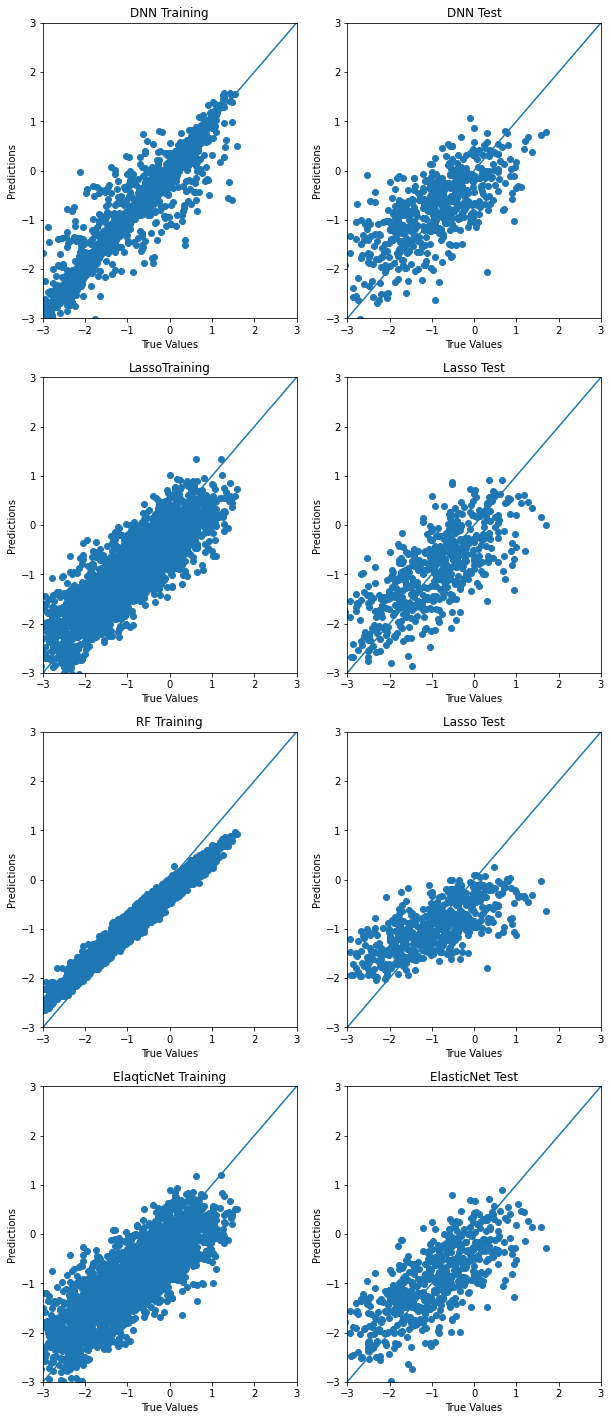

In [13]:
plt.figure(figsize=(10,25))

plt.subplot(421)
plt.scatter(y_train, train_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-3, 3]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title('DNN Training')

plt.subplot(422)
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-3, 3]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title('DNN Test')

plt.subplot(423)
plt.scatter(y_train, pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-3, 3]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title('LassoTraining')

plt.subplot(424)
plt.scatter(y_test, pred_test)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-3, 3]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title('Lasso Test')

plt.subplot(425)
plt.scatter(y_train, pred_rf)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-3, 3]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title('RF Training')

plt.subplot(426)
plt.scatter(y_test, pred_test_rf)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-3, 3]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title('Lasso Test')

plt.subplot(427)
plt.scatter(y_train, pred_en)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-3, 3]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title('ElaqticNet Training')

plt.subplot(428)
plt.scatter(y_test, pred_test_en)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-3, 3]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title('ElasticNet Test')

print('DNN Results')
print("rmse train:", np.sqrt(mean_squared_error(y_train, train_predictions)))
print("rmse test: ", np.sqrt(mean_squared_error(y_test, test_predictions)))
print()
print('Lasso Results')
print("rmse train:", np.sqrt(mean_squared_error(y_train, pred)))
print("rmse test: ", np.sqrt(mean_squared_error(y_test, pred_test)))
print()
print('RF Results')
print("rmse train:", np.sqrt(mean_squared_error(y_train, pred_rf)))
print("rmse test: ", np.sqrt(mean_squared_error(y_test, pred_test_rf)))
print()
print('ElasticNet Result')
print("rmse train:", np.sqrt(mean_squared_error(y_train, pred_en)))
print("rmse test: ", np.sqrt(mean_squared_error(y_test, pred_test_en)))
print()
moy_pred = pd.DataFrame(y_test)
moy_pred['Lasso'] = pred_test
moy_pred['DNN']=test_predictions
moy_pred['rf']=pred_test_rf
moy_pred['en']=pred_test_en
moy_pred['moy_1_2_3']=(moy_pred.DNN+moy_pred.Lasso+moy_pred.rf)/3
moy_pred['moy_1_2_4']=(moy_pred.DNN+moy_pred.Lasso+moy_pred.en)/3
moy_pred['moy_1_3_4']=(moy_pred.DNN+moy_pred.rf+moy_pred.en)/3
moy_pred['moy_2_3_4']=(moy_pred.Lasso+moy_pred.rf+moy_pred.en)/3
moy_pred['moy_1_2']=(moy_pred.DNN+moy_pred.Lasso)/2
moy_pred['moy_1_3']=(moy_pred.DNN+moy_pred.rf)/2
moy_pred['moy_1_4']=(moy_pred.DNN+moy_pred.en)/2
moy_pred['moy_2_3']=(moy_pred.Lasso+moy_pred.rf)/2
moy_pred['moy_2_4']=(moy_pred.Lasso+moy_pred.en)/2
moy_pred['moy_3_4']=(moy_pred.rf+moy_pred.en)/2
moy_pred['moy']=(moy_pred.DNN+moy_pred.Lasso+moy_pred.rf+moy_pred.en)/4
moy_pred.head()
print("rmse test moy_1_2: ", np.sqrt(mean_squared_error(y_test, moy_pred.moy_1_2)))
print("rmse test moy_1_3: ", np.sqrt(mean_squared_error(y_test, moy_pred.moy_1_3)))
print("rmse test moy_2_3: ", np.sqrt(mean_squared_error(y_test, moy_pred.moy_2_3)))
print("rmse test moy_1_4: ", np.sqrt(mean_squared_error(y_test, moy_pred.moy_1_4)))
print("rmse test moy_2_4: ", np.sqrt(mean_squared_error(y_test, moy_pred.moy_2_4)))
print("rmse test moy_3_4: ", np.sqrt(mean_squared_error(y_test, moy_pred.moy_3_4)))
print("rmse test moy_1_2_3: ", np.sqrt(mean_squared_error(y_test, moy_pred.moy_1_2_3)))
print("rmse test moy_1_2_4: ", np.sqrt(mean_squared_error(y_test, moy_pred.moy_1_2_4)))
print("rmse test moy_1_3_4: ", np.sqrt(mean_squared_error(y_test, moy_pred.moy_1_3_4)))
print("rmse test moy_2_3_4: ", np.sqrt(mean_squared_error(y_test, moy_pred.moy_2_3_4)))
print("rmse test moy: ", np.sqrt(mean_squared_error(y_test, moy_pred.moy)))

df_sub = pd.read_csv('sample_submission.csv')
df_sub_results = pd.DataFrame(df_sub_results)
df_sub_results['DNN'] = sub_predictions
df_sub_results['Lasso'] = pred_sub
df_sub_results['RF'] = pred_sub_rf
df_sub_results['EN'] = pred_sub_en
df_sub_results['moy']= (df_sub_results.DNN+df_sub_results.Lasso+df_sub_results.RF+df_sub_results.EN)/4

In [14]:
df_sub_results.head(7)

,identifiant_,DNN,Lasso,RF,EN,moy
2834,c0f722661,-0.355081,-0.532380,-0.683633,-0.269125,-0.460055
2835,f0953f0a5,-0.644377,-0.791899,-0.436295,-0.662499,-0.633767
2836,0df072751,-0.535928,-0.332567,-0.423862,-0.321538,-0.403474
2837,04caf4e0c,-1.258801,-1.459278,-1.738990,-1.861964,-1.579758
2838,0e63f8bea,-1.266041,-1.452980,-1.611380,-1.705043,-1.508861
2839,12537fe78,0.019898,-0.628776,-0.781583,-0.952580,-0.585760
2840,965e592c0,-0.103932,0.582495,-0.309112,0.372900,0.135588


In [15]:
df_sub['target'] = list(df_sub_results.moy)
df_sub.head(7)

,id,target
0,c0f722661,-0.460055
1,f0953f0a5,-0.633767
2,0df072751,-0.403474
3,04caf4e0c,-1.579758
4,0e63f8bea,-1.508861
5,12537fe78,-0.585760
6,965e592c0,0.135588


In [16]:
df_sub.to_csv("submission.csv", index=False)